## Pre-trained models using keras
Chapter 5 from [Deep Learning: Image Recognition course](https://www.linkedin.com/learning/deep-learning-image-recognition/pre-trained-neural-networks-included-with-keras) on Linkedin Learning.

In [26]:
from keras.preprocessing import image
from keras.applications import vgg16
import numpy as np
from pathlib import Path
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Download vgg16 pre-trained model.

In [2]:
model = vgg16.VGG16()

Open image, convert it to array and add one more dimension to feed it to keras.

In [19]:
img = image.load_img('./img/bay.jpg', target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

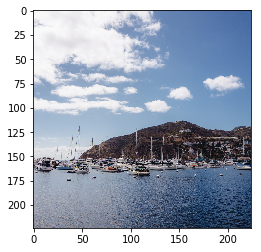

In [20]:
pylab.imshow(img)

Normalize vector values using built-in vgg function.

In [21]:
x = vgg16.preprocess_input(x)

Make prediction and show top 9 predictions.

In [22]:
pred = model.predict(x)

In [23]:
predicted_class = vgg16.decode_predictions(pred, top=9)

In [24]:
print("Top predictors:")
for img_id, name, prob in predicted_class[0]:
    print("Prediction: {} - {:f}".format(name, prob))

Top predictors:
Prediction: seashore - 0.395212
Prediction: promontory - 0.326130
Prediction: lakeside - 0.119613
Prediction: breakwater - 0.062801
Prediction: sandbar - 0.045267
Prediction: cliff - 0.011845
Prediction: dock - 0.009196
Prediction: boathouse - 0.003278
Prediction: valley - 0.003194


### Dog or Not-dog using pre-trained NN. Transfer Learning.

Reuse an existing neural network which was learnt on some data. We can take convolutional layers and cut off dense and output layers. The convolutional layers will be a feature extractor for a new model.

In [63]:
dog_path = Path('./dogs')
not_dog_path = Path('./not_dogs')

Read training images and label them.

In [64]:
images = []
labels = []
for img in not_dog_path.glob("*.png"):
    tmp_img = image.load_img(img)
    image_array = image.img_to_array(tmp_img)
    images.append(image_array)
    # use label 0 for not-dogs 
    labels.append(0)

for img in dog_path.glob("*.png"):
    tmp_img = image.load_img(img)
    image_array = image.img_to_array(tmp_img)
    images.append(image_array)
    # use label 1 for dogs 
    labels.append(1)

In [66]:
x_train = np.array(images)
y_train = np.array(labels)

Use imagenet pre-trained neural network's convolutional layers (excluding last dense layer) to make feature selection based on imagenet.

In [68]:
pretrained_nn = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

58892288/58889256 [==============================] - 42s 1us/step


We will use the output of the imagenet convolutional layers as an input for our dense layer.

In [75]:
features_x = pretrained_nn.predict(x_train)